In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv("TCS.csv")
candidate_sentences.shape

(715, 1)

In [ ]:
candidate_sentences.head()

,text
0,TOP Losers MphasiS Down Infosys Shrink TechMahindra Loses Wipro Falls HCLTech Down …
1,Listen to Josh Bersin and other industry leaders talk about how to maximize value from HumanCapitalManagement inve…
2,Take the free TCS NQT Mock Test to improve your chances of getting selected Register Now to take the test…
3,TCS coming to zoneNeed some positive price actionRisk reward favourable as stop is smaller
4,Prediction was correct TCS did not close above


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["text"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 715/715 [00:07<00:00, 91.71it/s]


In [ ]:
entity_pairs[10:20]

[['', ''],
 ['TCS', 'Two Awards TCS telecomdrive'],
 ['', 'you'],
 ['TCS', 'Cloud Security Services'],
 ['Exited TCS CE', 'StockMarket trading'],
 ['Exited TCS CE', 'StockMarket trading investing'],
 ['TCS', 'Two Microsoft Year'],
 ['why IT sector', 'medium term heres'],
 ['> Quiz Which', 'following BB search engine'],
 ['TCS', 'Two  major']]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['text'])]

100%|██████████| 715/715 [00:07<00:00, 94.04it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

TCS                   15
is                    15
helps                 11
>                      9
visit                  8
Announcement under     8
Services               7
tcs                    7
are correct            7
Ask                    6
ratios fo              6
are                    6
was                    6
In                     5
invest                 5
chart                  5
acc                    5
investing              5
TradingView            5
Tcs                    5
expecting              5
spur fiveyear          4
was correct            4
delayed                4
Join                   3
Buy                    3
o                      3
Steal                  3
Time for               3
frontpageapp           3
Follow                 3
needs                  3
Manager                3
CCIM                   3
Stocks for             3
Check                  3
adds over              3
hiring over            3
close                  3
results                3


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

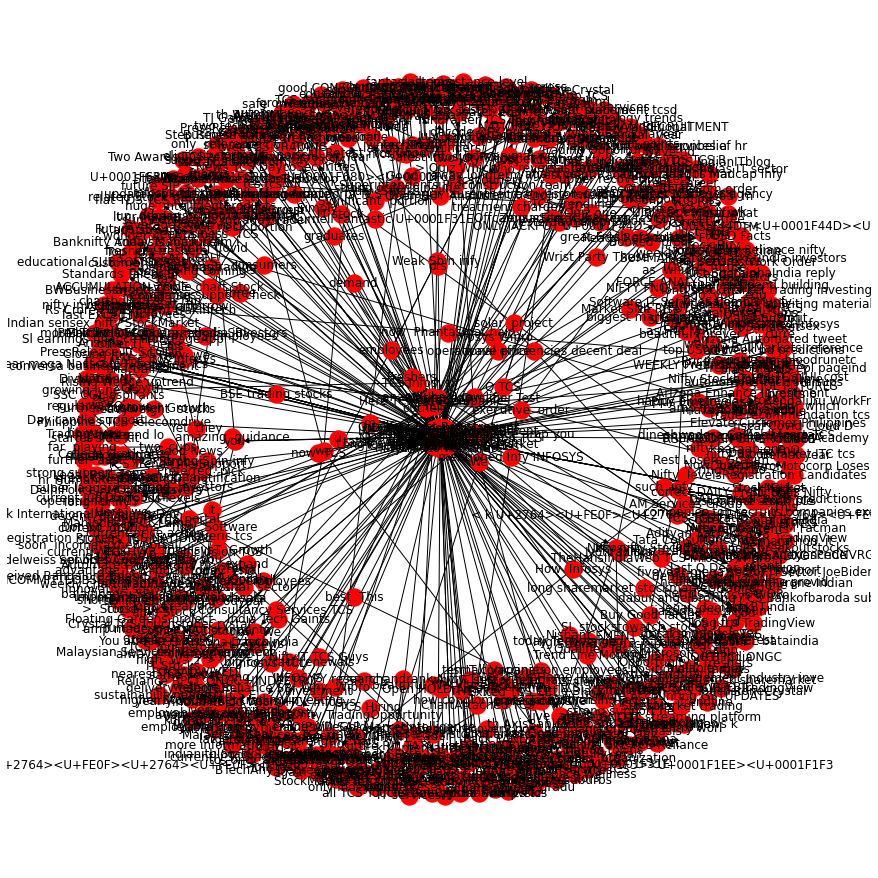

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df['edge'].unique()

array(['HCLTech', 'talk about', 'Take', 'coming to', 'was correct',
       'are correct', 'Employees From', 'trade', 'Services',
       'Announcement under', 'Is', 'Wins', 'Thank', 'TCS', 'bought at',
       'Microsoft', 'prefer', 'acquire', 'hold', 'Looks good', 'Save',
       'sharemarket', 'is because', 'doing', 'are high', 'are', 'Steal',
       'suchetadalal', 'freecodes', 'expecting', 'adds', 'AsianPaints',
       'fiddling', 'are grateful', 'tren', 'which', 'appear', 'GAPD',
       'be', 'socialmedia', 'creativetalk', 'design', 'Designer', 'visit',
       'fo', 'bombaydyeing', 'Sell below', 'Follow', 'is in',
       'approaching', 'Reward', 'ratios for', '>', 'ratios fo',
       'growth at', 'Opens', 'reverse from', 'technolo', 'Need', 'helps',
       'chart', 'Ask', 'come', 'enter', 'Grow to', 'buy', 'Our', 'srf',
       'reclaim', 'is', 'Larsenandtoubro', 'reve', 'hcltech', 'tcsnqt',
       'placeme', 'has', 'Business', 'are wonderful', 'Playing in',
       'Join', 'Go', 'want

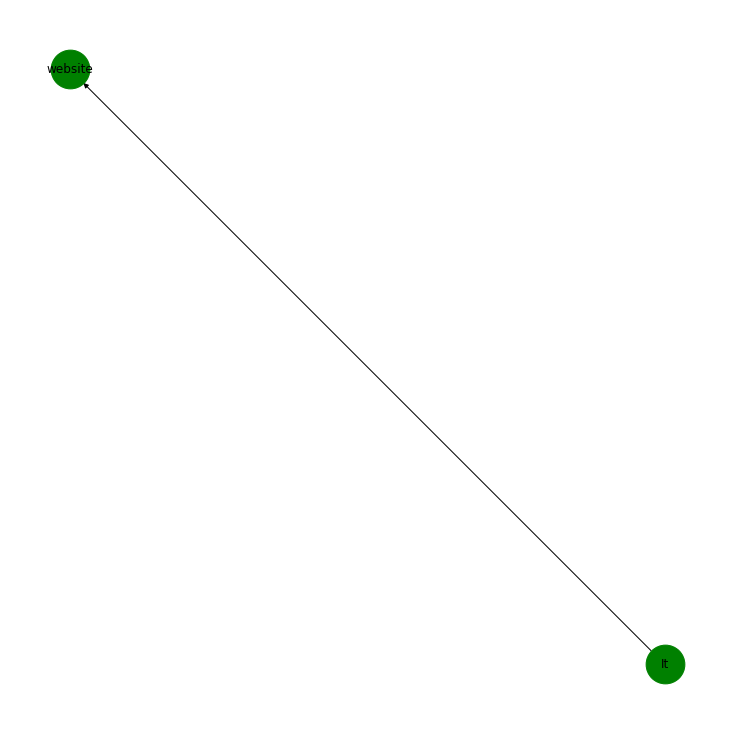

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="works"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k = 5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='green', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()